In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d
from scipy.spatial.transform import Rotation as R

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
# cluster 77 came from z ~25
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
### ADDING THIS 20230421
supercluster_signals /= np.std(supercluster_signals,axis=1)[:,np.newaxis]

In [5]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX']; shorts = ['Y', 'Z', 'X']

fictrac = {'Y': [], 'Z': [], 'X': []}

for fly in fly_names:
    fly_dir = os.path.join(dataset_path, fly)
    fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'func_0', 'fictrac'))
    for behavior, short in zip(behaviors, shorts):
        fictrac[short].append(fictrac_raw[behavior])

for short in shorts:    
    fictrac[short] = np.asarray(fictrac[short])


~~ load_fictrac ~~
load_fictrac done. Duration: 1.82 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.85 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.86 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.87 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.89 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.91 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.89 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.89 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 1.89 sec


In [6]:
fictrac_data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))
r = R.from_euler('xyz', [-6.46013698, -12.92761252,   3.29629772], degrees=True).as_dcm()
fictrac_data_r = np.matmul(fictrac_data.T,r).T

fictrac_data_rotated = {'Y': fictrac_data_r[1,:],
                        'Z': fictrac_data_r[2,:]}

In [7]:
# Create camera timepoints
fps=50
camera_rate = 1/fps * 1000 # camera frame rate in ms
expt_len = 1000*30*60
x_original = np.arange(0,expt_len,camera_rate)

# new timepoints
width = 30000 
step = 20 #in ms
time_shifts = list(range(-width,width,step))
xs = np.asarray(time_shifts)/1000

# neural timepoints
file = os.path.join(dataset_path, 'fly_087', 'func_0', 'imaging')
neural_timestamps = brainsss.load_timestamps(file)

Trying to load timestamp data from hdf5 file.
Success.


In [8]:
step = 90000
sliding_fictrac = {}
for beh in ['Y', 'Z']:
    print(beh)

    all_behavior_shifts = []
    for k,fly in enumerate(fly_names):
        
        # Smooth fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(fictrac_data_rotated[beh][step*k:step*(k+1)],25,3)

        # Create interp object with camera timepoints
        interp_obj = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        
        behavior_shifts = []
        for shift in time_shifts:
            fictrac_interp = interp_obj(neural_timestamps[:,20]+shift)#flies[fly].timestamps[:,z]+shift)
            fictrac_interp = np.nan_to_num(fictrac_interp)
            behavior_shifts.append(fictrac_interp)
        all_behavior_shifts.append(np.asarray(behavior_shifts))
    all_behavior_shifts = np.asarray(all_behavior_shifts)
    sliding_fictrac[beh] = np.reshape(np.moveaxis(all_behavior_shifts,0,1),(-1,30456))

Y
Z


In [9]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data,
                num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], test['pc_count']

In [10]:
cluster = 77

all_2d_hists = []
bin_counts = []
for j,shift in tqdm.tqdm(enumerate(np.arange(0,3000,100))):
    Y_var = sliding_fictrac['Z'][shift,:].copy()
    Y_var /= np.std(sliding_fictrac['Z'][1500,:])

    X_var = sliding_fictrac['Y'][shift,:].copy()
    X_var /= np.std(sliding_fictrac['Y'][1500,:])

    start_x=-2; end_x=6; start_y=-4; end_y=4

    signal = supercluster_signals[cluster,:]-supercluster_signals[cluster+250,:]
    fictrac_2d, bin_count = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    all_2d_hists.append(fictrac_2d)
    bin_counts.append(bin_count)


#all_2d_hists = np.reshape(np.asarray(all_2d_hists),(2,400,25,25))
#print(all_2d_hists.shape)

30it [00:01, 19.01it/s]


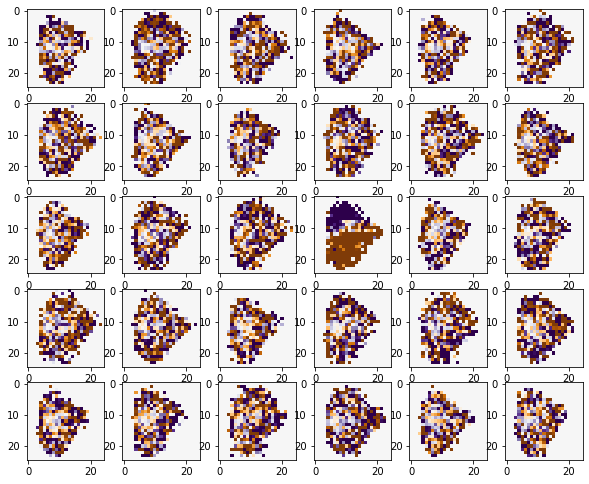

In [11]:
plt.figure(figsize=(10,10))
for k,i in enumerate(np.arange(30)):
    plt.subplot(6,6,k+1)
    plt.imshow(all_2d_hists[i],vmin=-.2,vmax=.2,cmap='PuOr')

In [12]:
cluster = 77
clusters = [77,185,186]
clusters_ = [i+250 for i in clusters]

all_2d_hists = []
bin_counts = []

shift = 1500
Y_var = sliding_fictrac['Z'][shift,:].copy()
Y_var /= np.std(sliding_fictrac['Z'][1500,:])

X_var = sliding_fictrac['Y'][shift,:].copy()
X_var /= np.std(sliding_fictrac['Y'][1500,:])

start_x=-2; end_x=6; start_y=-4; end_y=4

signal = np.mean(supercluster_signals[clusters,:],axis=0)-np.mean(supercluster_signals[clusters_,:],axis=0)
fictrac_2d, bin_count = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

fictrac_2d[-1,:] = 0
all_2d_hists.append(fictrac_2d)
bin_counts.append(bin_count)


#all_2d_hists = np.reshape(np.asarray(all_2d_hists),(2,400,25,25))
#print(all_2d_hists.shape)

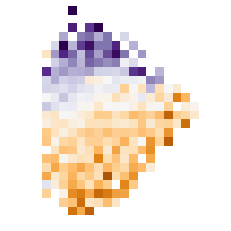

In [14]:
to_plot = np.mean(all_2d_hists,axis=0)
to_plot[np.where(to_plot==0)] = np.nan
plt.imshow(to_plot,vmin=-.2,vmax=.2,cmap='PuOr')
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [39]:
time_shifts[0], time_shifts[750], time_shifts[1100], time_shifts[1480]

(-30000, -15000, -8000, -400)

In [41]:
time_shifts[1520], time_shifts[1900]

(400, 8000)

In [195]:
#20 ms steps
time_shifts[1900], time_shifts[2250]

(8000, 15000)

In [89]:
time_shifts[2000], time_shifts[2200]

(10000, 14000)

In [85]:
time_shifts[1000], time_shifts[800]

(-10000, -14000)

In [58]:
time_shifts[1350], time_shifts[1200]

(-3000, -6000)

In [64]:
time_shifts[1650], time_shifts[1800]

(3000, 6000)

In [24]:
clusters = [27]#[77,185,186]
clusters_ = [i+250 for i in clusters]
signal = np.mean(supercluster_signals[clusters,:],axis=0)-np.mean(supercluster_signals[clusters_,:],axis=0)

windows = [(0,750),(750,1100),(1100,1480),(1480,1520),(1520,1900),(1900,2250),(2250,3000)]

all_2d_hists = []
all_bin_counts = []
for window in windows:
    
    start = window[0]
    stop = window[1]
    
    _2d_hists = []
    bin_counts = []
    
    for j,shift in tqdm.tqdm(enumerate(np.arange(start,stop,2))):



        Y_var = sliding_fictrac['Z'][shift,:].copy()
        Y_var /= np.std(sliding_fictrac['Z'][1500,:])

        X_var = sliding_fictrac['Y'][shift,:].copy()
        X_var /= np.std(sliding_fictrac['Y'][1500,:])

        start_x=-2; end_x=6; start_y=-4; end_y=4


        fictrac_2d,bin_count = bin_2D_plot(X_var, Y_var, signal,
                                         num_bins_x=25, num_bins_y=25,
                                         start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                         min_num_samples=9)

        fictrac_2d[-1,:] = 0
        _2d_hists.append(fictrac_2d)
        bin_counts.append(bin_count)
    all_2d_hists.append(np.asarray(_2d_hists))
    all_bin_counts.append(np.asarray(bin_counts))

375it [00:19, 19.01it/s]
175it [00:09, 18.92it/s]
190it [00:10, 18.92it/s]
20it [00:01, 18.89it/s]
190it [00:10, 18.98it/s]
175it [00:09, 19.03it/s]
375it [00:19, 18.97it/s]


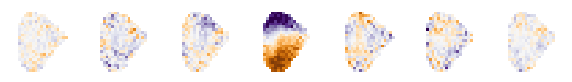

In [26]:
plt.figure(figsize=(10,2))
for k,window in enumerate([6,5,4,3,2,1,0]):
    plt.subplot(1,7,k+1)
    to_plot = np.mean(all_2d_hists[window],axis=0)
    to_plot[np.where(np.mean(all_bin_counts[window],axis=0)<9)] = np.nan
    to_plot[-1,:] = np.nan
    
    # IPS values
    if k == 3:
        plt.imshow(to_plot,vmin=-.5,vmax=.5,cmap='PuOr')
    else:
        plt.imshow(to_plot,vmin=-.12,vmax=.12,cmap='PuOr')
    # LH values
#     if k == 3:
#         plt.imshow(to_plot,vmin=-.3,vmax=.3,cmap='PuOr')
#     else:
#         plt.imshow(to_plot,vmin=-.05,vmax=.05,cmap='PuOr')

    #plt.imshow(to_plot,vmin=-.01,vmax=.01,cmap=parula)
    #plt.title('.4')

    plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

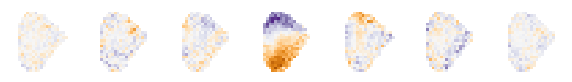

In [23]:
plt.figure(figsize=(10,2))
for k,window in enumerate([6,5,4,3,2,1,0]):
    plt.subplot(1,7,k+1)
    to_plot = np.mean(all_2d_hists[window],axis=0)
    to_plot[np.where(np.mean(all_bin_counts[window],axis=0)<9)] = np.nan
    to_plot[-1,:] = np.nan
    
    # IPS values
    if k == 3:
        plt.imshow(to_plot,vmin=-.5,vmax=.5,cmap='PuOr')
    else:
        plt.imshow(to_plot,vmin=-.12,vmax=.12,cmap='PuOr')
    # LH values
#     if k == 3:
#         plt.imshow(to_plot,vmin=-.3,vmax=.3,cmap='PuOr')
#     else:
#         plt.imshow(to_plot,vmin=-.05,vmax=.05,cmap='PuOr')

    #plt.imshow(to_plot,vmin=-.01,vmax=.01,cmap=parula)
    #plt.title('.4')

    plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

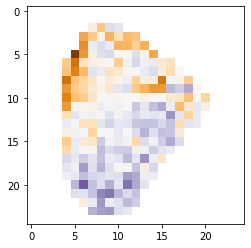

In [191]:
to_plot = np.mean(all_2d_hists,axis=0)
to_plot[np.where(np.mean(bin_counts,axis=0)<9)] = np.nan
to_plot[-1,:] = np.nan
plt.imshow(to_plot,vmin=-.02,vmax=.02,cmap='PuOr')
#plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [175]:
to_plot[np.where(to_plot==0)] = np.nan

# Bin behavior in neural space

In [10]:
def NormalizeData(data):
    data = np.nan_to_num(data)
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [23]:
np.std(supercluster_signals[cluster,:])

0.14938528611403573

In [38]:
cluster = 77#62#112#39#77
x_data = supercluster_signals[cluster,:] / np.std(supercluster_signals[cluster,:])
y_data = supercluster_signals[cluster+250,:] / np.std(supercluster_signals[cluster+250,:])

# x_data = np.mean(supercluster_signals[[77,185,186],:],axis=0)
# y_data = np.mean(supercluster_signals[[77+250,185+250,186+250],:],axis=0)

shift = 1500
#behavior = sliding_fictrac['Z'][shift,:].copy()* 180 / np.pi * fps
sphere_radius = 4.5e-3 # in m
behavior = sliding_fictrac['Y'][shift,:].copy() * sphere_radius * fps * 1000


start=-.6
stop=.6
start=-4
stop=4
num_bins=30#40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        #binned_signal.append(np.mean(behavior[mask]))
        
        #turn
#         try:
#             thresh = np.percentile(np.abs(behavior[mask]),90)
#             indicies = np.abs(behavior[mask])>thresh
#             binned_signal.append(np.mean(behavior[mask][indicies]))
#         except IndexError:
#             binned_signal.append(np.nan)
     
        ###fwd
        try:
            binned_signal.append(np.percentile(behavior[mask],90))
        except IndexError:
            binned_signal.append(np.nan)
            
            
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

In [76]:
np.mean(behavior[mask])

nan

In [53]:
# cluster = 77
# x_data = supercluster_signals[cluster,:]
# y_data = supercluster_signals[cluster+250,:]

# binned_signals = []
# for j,shift in tqdm.tqdm(enumerate(np.arange(1900,2250,2))):

#     behavior = sliding_fictrac['Z'][shift,:].copy()* 180 / np.pi * fps

#     start=-.6
#     stop=.6
#     num_bins=40
#     min_num_samples=10

#     # Define bins
#     bins = np.linspace(start,stop,num_bins)

#     # Assign neural values to bin numbers
#     idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

#     binned_signal = []
#     sample_count = []
#     for i in range(num_bins):
#         mask_x = (idx_x == i)
#         for j in range(num_bins):
#             mask_y = (idx_y == j)
#             mask = mask_x & mask_y

#             binned_signal.append(np.mean(behavior[mask]))
#             sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

#     binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
#     sample_count = np.reshape(sample_count,(num_bins, num_bins))
#     binned_signals.append(binned_signal)
# binned_signals = np.asarray(binned_signals)
# binned_signals.shape

In [13]:
### MAKE R/G MAP ###
cmap1 = mcolors.LinearSegmentedColormap.from_list('mycmap', ['red', 'k'])
cmap2 = mcolors.LinearSegmentedColormap.from_list('mycmap', ['k', '#00FF00'])

colors1 = cmap1(np.linspace(0, .7, 128))
colors2 = cmap2(np.linspace(.1, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
RG_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

### MAKE BLUE MAKE ###
blue_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', ['w', 'blue'])

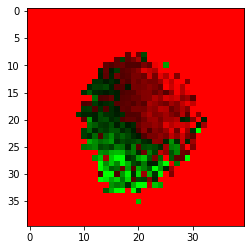

In [15]:
turn_map = RG_map((binned_signal+50)/100).copy()
plt.imshow(turn_map)

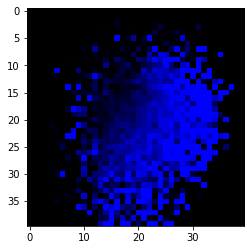

In [79]:
fwd_map = blue_cmap(binned_signal/2).copy()
plt.imshow(fwd_map)

In [73]:
fwd_map[20,20]

array([0., 0., 1., 1.])

In [45]:
turn_map.shape

(40, 40, 4)

In [69]:
binned_signal.shape

(40, 40)

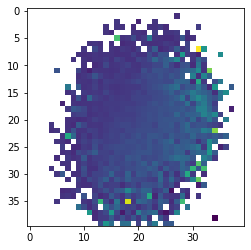

In [68]:
plt.imshow(binned_signal)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


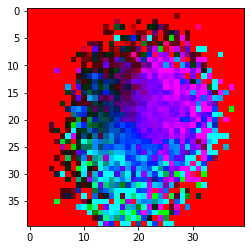

In [94]:
merge = fwd_map+turn_map/2
merge = NormalizeData(merge)*3
plt.imshow(merge)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


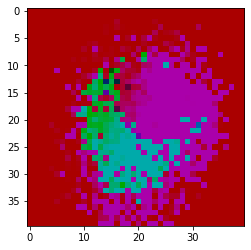

In [39]:
out = np.sum(np.stack((turn_map/1.5, fwd_map/1.5)),axis=0)
plt.imshow(out)

In [72]:
##-4 to 4 zscore
np.linspace(-4,4,30)

array([-4.        , -3.72413793, -3.44827586, -3.17241379, -2.89655172,
       -2.62068966, -2.34482759, -2.06896552, -1.79310345, -1.51724138,
       -1.24137931, -0.96551724, -0.68965517, -0.4137931 , -0.13793103,
        0.13793103,  0.4137931 ,  0.68965517,  0.96551724,  1.24137931,
        1.51724138,  1.79310345,  2.06896552,  2.34482759,  2.62068966,
        2.89655172,  3.17241379,  3.44827586,  3.72413793,  4.        ])

In [111]:
np.linspace(-4,4,30)[7]

-2.0689655172413794

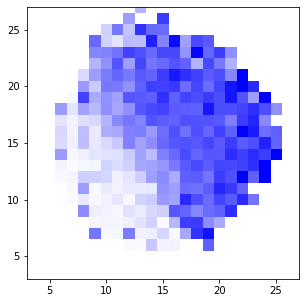

In [39]:
plt.figure(figsize=(5,5))
binned_signal[np.where(sample_count<10)] = np.nan


#plt.imshow(np.mean(binned_signals,axis=0),cmap=mymap,vmin=-20,vmax=20)
#plt.imshow(binned_signal,cmap=RG_map,vmin=-200,vmax=200) #TURNING

plt.imshow(binned_signal,cmap=blue_cmap,vmin=0,vmax=8) #FWD
#plt.imshow(binned_signal,cmap='seismic',vmin=-.015,vmax=.015)

# plt.xticks([10,20,30],[-.3,0,.3]);
# plt.yticks([10,20,30],[-.3,0,.3]);
ax = plt.gca()
ax.invert_yaxis()

#plt.plot([0,50],[0,50],color='k',linestyle='--')
#plt.axhline(15,color='k',linestyle='-')
#plt.axvline(15,color='k',linestyle='-')

plt.xlim(3,27)
plt.ylim(3,27)

#plt.colorbar()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [360]:
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', ['green', 'red'])

In [289]:
bins[10]

-0.2923076923076923

In [315]:
import matplotlib.colors as mcolors


parula_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula = mcolors.LinearSegmentedColormap.from_list('my_colormap', parula_data)